The RAFT model outputs lists of predicted flows where each entry is a
(N, 2, H, W) batch of predicted flows that corresponds to a given "iteration"
in the model. For more details on the iterative nature of the model, please
refer to the `original paper <https://arxiv.org/abs/2003.12039>`_. Here, we
are only interested in the final predicted flows (they are the most acccurate
ones), so we will just retrieve the last item in the list.

As described above, a flow is a tensor with dimensions (2, H, W) (or (N, 2, H,
W) for batches of flows) where each entry corresponds to the horizontal and
vertical displacement of each pixel from the first image to the second image.
Note that the predicted flows are in "pixel" unit, they are not normalized
w.r.t. the dimensions of the images.



In [ ]:
# %%capture
%matplotlib inline
!pip install av
!pip install torchvision==0.12.0
!pip install pytube

# RESTART RUNTIME AFTER INSTALL

In [ ]:
#  <https://arxiv.org/abs/2003.12039>

import shutil
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.transforms as T
import torchvision
from torchvision.utils import flow_to_image
from torchvision.models.optical_flow import raft_large
from torchvision.io import read_video
from pytube import YouTube
from tqdm.notebook import tqdm
import tempfile
from pathlib import Path
from urllib.request import urlretrieve
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

# shutil.unpack_archive("drive/MyDrive//Scientific ISR/PESMOD.zip", "/content/drive/My Drive/Scientific ISR/PESMOD")

device = "cuda" if torch.cuda.is_available() else "cpu"

model = raft_large(pretrained=True, progress=False).to(device)
model = model.eval()

plt.rcParams["savefig.bbox"] = "tight"
# sphinx_gallery_thumbnail_number = 2


def plot(imgs, figsize=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False, figsize=figsize)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()


def preprocess(batch):
# image dimension must be divisible by 8
    transforms = T.Compose(
        [
            T.ConvertImageDtype(torch.float32),
            T.Normalize(mean=0.5, std=0.5),  # map [0, 1] into [-1, 1]
            T.Resize(size=(520, 960)),
        ]
    )
    batch = transforms(batch)
    return batch

def download_youtube(videourl, path):
  yt = YouTube(videourl)
  # title = yt.streams[0].title
  yt = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()
  if not os.path.exists(path):
      os.makedirs(path)
  yt.download(path)
  # return title

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# download_youtube("https://www.youtube.com/watch?v=P4jy_n03GqI", "/content/drive/My Drive/Scientific ISR/YouTube/Borodyanka.mp4")

In [ ]:
frames, img1_batch, img2_batch, list_of_flows, predicted_flows, flow_imgs, grid = [], [], [], [], [], [], []

video_path = "/content/drive/My Drive/Scientific ISR/YouTube/Mariupol.mp4"

frames, _, _ = read_video(video_path, start_pts=7, end_pts=13, pts_unit="sec")
frames = frames.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
frames.shape

torch.Size([151, 3, 720, 1280])

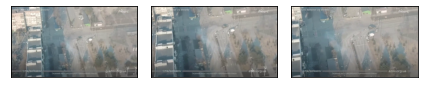

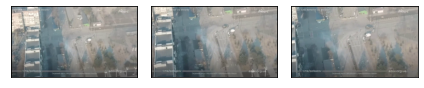

In [ ]:
indices = 0, 50, 100 #, 149 #, 169, 200
img1_batch = torch.stack([frames[i] for i in indices])
img2_batch = torch.stack([frames[i + 3] for i in indices])

plot(img1_batch)
plot(img2_batch)

shape = torch.Size([3, 3, 520, 960]), dtype = torch.float32
type = <class 'list'>
length = 12 = number of iterations of the model
dtype = torch.float32
shape = torch.Size([3, 2, 520, 960]) = (N, 2, H, W)
min = -35.99337387084961, max = 13.158082008361816


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

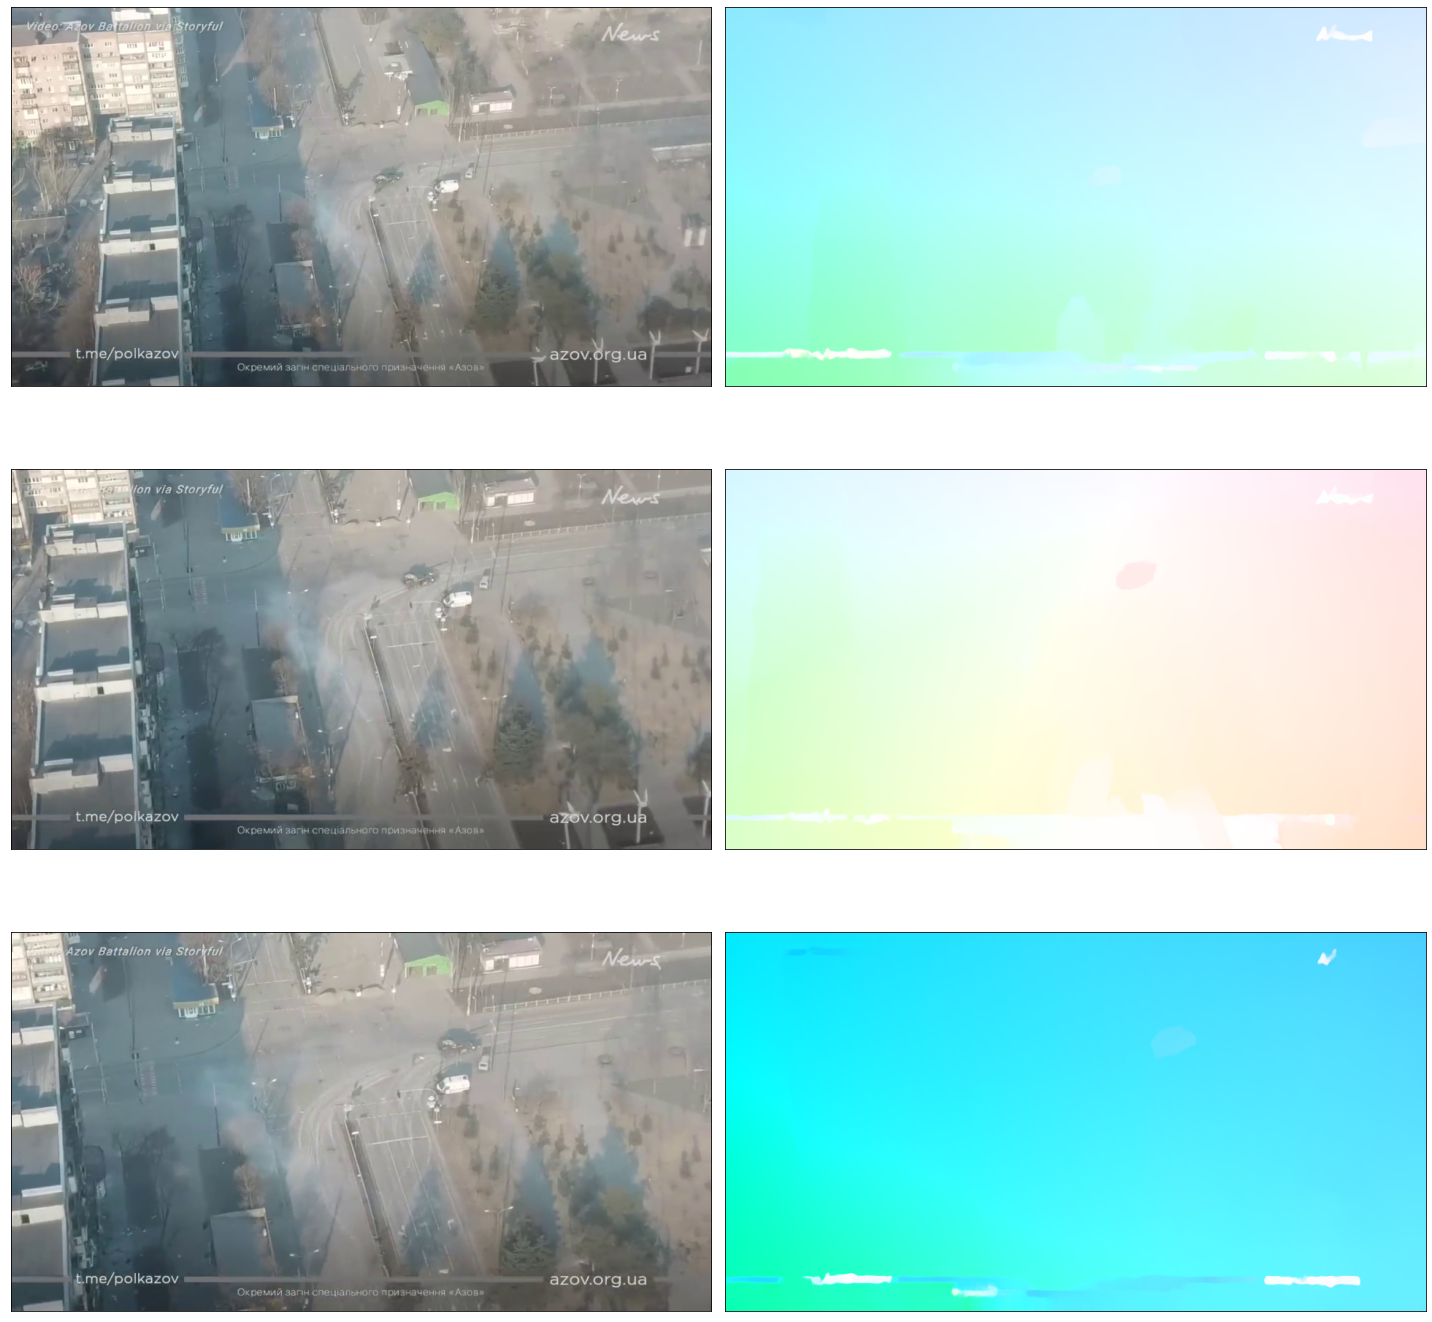

In [ ]:
img1_batch_preprocessed = preprocess(img1_batch).to(device)
img2_batch_preprocessed = preprocess(img2_batch).to(device)

print(f"shape = {img1_batch_preprocessed.shape}, dtype = {img1_batch_preprocessed.dtype}")

with torch.no_grad():
    list_of_flows = model(
        img1_batch_preprocessed.to(device),
        img2_batch_preprocessed.to(device)
    )
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

flow_imgs = flow_to_image(predicted_flows)

# The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
img1_batch_preprocessed = [(img1 + 1) / 2 for img1 in img1_batch_preprocessed]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch_preprocessed, flow_imgs)]
plot(grid, figsize=(20, 20))
plt.savefig("test.png", dpi=400)
files.download("test.png") 